## Setup Environment

In [2]:
# install libraries
! pip install transformers
#! pip install pycaret


[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: C:\Users\erikf\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [3]:
#import libraries
import numpy as np
import pandas as pd
#import pycaret
import transformers
from transformers import AutoModel, BertTokenizerFast
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix 
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import torch
import torch.nn as nn

device = torch.device("cuda")

C:\Users\erikf\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
#mount to google collab
#from google.colab import drive
#drive.mount('/content/drive')

## Load Dataset

In [4]:
#load dataset
#dataset = pd.read_csv('myers_personality.csv')
dataset = pd.read_csv('D:\myers_personality.csv')


##Exploratory Analysis

In [5]:
#look into dataset
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8675 entries, 0 to 8674
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   type    8675 non-null   object
 1   posts   8675 non-null   object
dtypes: object(2)
memory usage: 135.7+ KB


In [6]:
#check if there are any missing data
dataset.isnull().any()

print('test')

test


In [7]:
personality_count = dataset.groupby(['type']).count().sort_values('posts', ascending=False)*50

Text(0.5, 1.0, 'Personality Type Distribution')

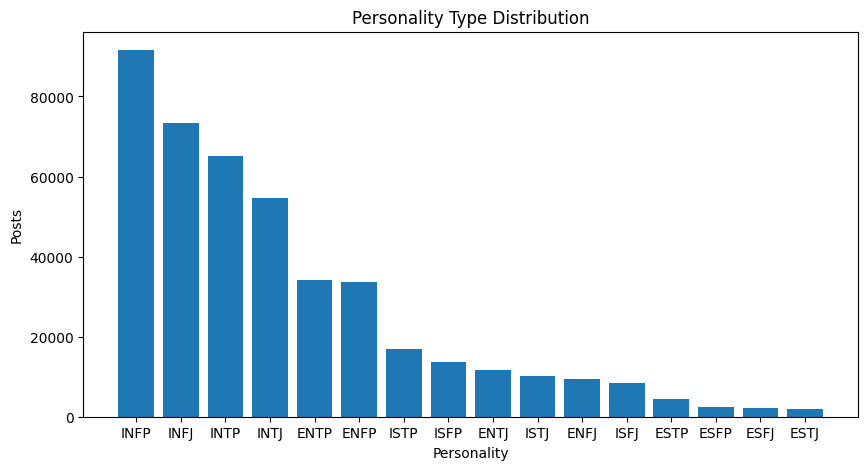

In [8]:
plt.figure(figsize = (10,5))
plt.bar(np.array(personality_count.index), height = personality_count['posts'],)
plt.xlabel('Personality', size = 10)
plt.ylabel('Posts', size = 10)
plt.title('Personality Type Distribution')

##Pre-Processing

In [9]:
# split 'posts' column by '|||' and add each type and split post to a new data frame
new_df = dataset[['type', 'posts']].apply(lambda x: pd.Series(x['posts'].split('|||')), axis=1).stack().reset_index(level=1, drop=True).to_frame('posts').join(dataset[['type']], how='left')

# display new data frame
print(new_df)

                                                  posts  type
0           'http://www.youtube.com/watch?v=qsXHcwe3krw  INFJ
0     http://41.media.tumblr.com/tumblr_lfouy03PMA1q...  INFJ
0     enfp and intj moments  https://www.youtube.com...  INFJ
0     What has been the most life-changing experienc...  INFJ
0     http://www.youtube.com/watch?v=vXZeYwwRDw8   h...  INFJ
...                                                 ...   ...
8674  I was going to close my facebook a few months ...  INFP
8674  30 Seconds to Mars - All of my collections. It...  INFP
8674  I have seen it, and i agree. I did actually th...  INFP
8674  Ok so i have just watched Underworld 4 (Awaken...  INFP
8674  I would never want to turn off my emotions. so...  INFP

[422845 rows x 2 columns]


In [10]:
# Extract the categorical labels into a separate Series
y_cat = new_df['type']

# Convert the categorical labels to numeric labels
y, label_names = pd.factorize(y_cat)

# Store the numeric labels in a new column of the DataFrame
new_df['label'] = y

In [11]:
new_df.head()

,posts,type,label
0,'http://www.youtube.com/watch?v=qsXHcwe3krw,INFJ,0
0,http://41.media.tumblr.com/tumblr_lfouy03PMA1q...,INFJ,0
0,enfp and intj moments https://www.youtube.com...,INFJ,0
0,What has been the most life-changing experienc...,INFJ,0
0,http://www.youtube.com/watch?v=vXZeYwwRDw8 h...,INFJ,0


In [12]:
new_df[new_df['posts'].str.contains('http:')==False]
new_df[new_df['posts'].str.contains('.com')==False]
new_df[new_df['posts'].str.contains('www.')==False]

,posts,type,label
0,http://41.media.tumblr.com/tumblr_lfouy03PMA1q...,INFJ,0
0,What has been the most life-changing experienc...,INFJ,0
0,May the PerC Experience immerse you.,INFJ,0
0,The last thing my INFJ friend posted on his fa...,INFJ,0
0,Hello ENFJ7. Sorry to hear of your distress. I...,INFJ,0
...,...,...,...
8674,I was going to close my facebook a few months ...,INFP,6
8674,30 Seconds to Mars - All of my collections. It...,INFP,6
8674,"I have seen it, and i agree. I did actually th...",INFP,6
8674,Ok so i have just watched Underworld 4 (Awaken...,INFP,6


## Train-test-split

In [13]:
# Train-Validation-Test set split into 70:15:15 ratio
# Train-Temp split
train_text, temp_text, train_labels, temp_labels = train_test_split(new_df['posts'], new_df['label'], 
                                                                    random_state=2018, 
                                                                    test_size=0.3, 
                                                                    stratify=new_df['type'])
# Validation-Test split
val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels, 
                                                                random_state=2018, 
                                                                test_size=0.5, 
                                                                stratify=temp_labels)

## BERT Fine-tuning

### Load pretrained BERT Model

In [14]:
# Load BERT model and tokenizer via HuggingFace Transformers
bert = AutoModel.from_pretrained('bert-base-uncased')
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


### Prepare Input Data

Text(0, 0.5, 'Number of texts')

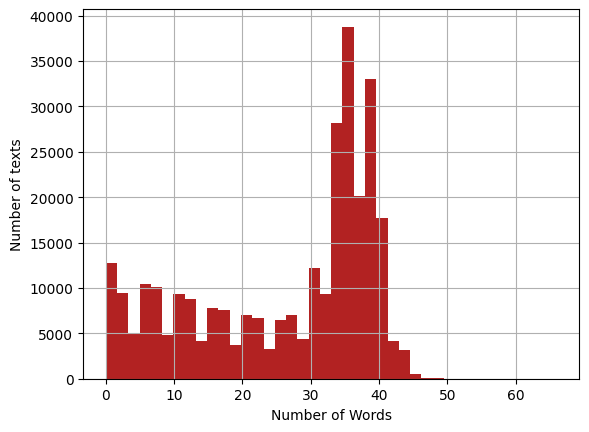

In [15]:
# Plot histogram of the number of words in train data 'title'
seq_len = [len(title.split()) for title in train_text]

pd.Series(seq_len).hist(bins = 40,color='firebrick')
plt.xlabel('Number of Words')
plt.ylabel('Number of texts')

In [16]:
# BERT Tokeizer Functionality
sample_data = ["Build personality test", 
               "Using bert."]                                         # sample data
tokenized_sample_data = tokenizer.batch_encode_plus(sample_data,
                                                    padding=True)     # encode text
print(tokenized_sample_data)

# Ref: https://huggingface.co/docs/transformers/preprocessing

{'input_ids': [[101, 3857, 6180, 3231, 102], [101, 2478, 14324, 1012, 102]], 'token_type_ids': [[0, 0, 0, 0, 0], [0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1], [1, 1, 1, 1, 1]]}


In [17]:
# Majority of titles above have word length under 40. So, we set max title length as 40
MAX_LENGHT = 40
# Tokenize and encode sequences in the train set
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = MAX_LENGHT,
    pad_to_max_length=True,
    truncation=True
)
# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = MAX_LENGHT,
    pad_to_max_length=True,
    truncation=True
)
# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = MAX_LENGHT,
    pad_to_max_length=True,
    truncation=True
)

C:\Users\erikf\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\transformers\tokenization_utils_base.py:2346: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [18]:
# Convert lists to tensors
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

In [19]:
# Data Loader structure definition
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
batch_size = 32                                               #define a batch size

train_data = TensorDataset(train_seq, train_mask, train_y)    # wrap tensors
train_sampler = RandomSampler(train_data)                     # sampler for sampling the data during training
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
                                                              # dataLoader for train set
val_data = TensorDataset(val_seq, val_mask, val_y)            # wrap tensors
val_sampler = SequentialSampler(val_data)                     # sampler for sampling the data during training
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)
                                                              # dataLoader for validation set

test_data = TensorDataset(test_seq, test_mask, test_y)            # wrap tensors
test_sampler = SequentialSampler(test_data)                     # sampler for sampling the data during training
test_dataloader = DataLoader(test_data, sampler = test_sampler, batch_size=batch_size)
                                                              # dataLoader for validation set

### Freeze Layers

In [20]:
# Freezing the parameters and defining trainable BERT structure
for param in bert.parameters():
    param.requires_grad = False    # false here means gradient need not be computed

### Define Model Architecture

In [21]:
class BERT_Arch(nn.Module):
    def __init__(self, bert):  
      super(BERT_Arch, self).__init__()
      self.bert = bert   
      self.dropout = nn.Dropout(0.1)            # dropout layer
      self.relu =  nn.ReLU()                    # relu activation function
      self.fc1 = nn.Linear(768,1024)             # dense layer 1
      self.fc2 = nn.Linear(1024,16)               # dense layer 2 (Output layer)
      self.softmax = nn.LogSoftmax(dim=1)       # softmax activation function
    def forward(self, sent_id, mask):           # define the forward pass  
      cls_hs = self.bert(sent_id, attention_mask=mask)['pooler_output']
                                                # pass the inputs to the model
      x = self.fc1(cls_hs)
      x = self.relu(x)
      x = self.dropout(x)
      x = self.fc2(x)                           # output layer
      x = self.softmax(x)                       # apply softmax activation
      return x

model = BERT_Arch(bert)
# Defining the hyperparameters (optimizer, weights of the classes and the epochs)
# Define the optimizer
from transformers import AdamW
optimizer = AdamW(model.parameters(),
                  lr = 0.001)          # learning rate
# Define the loss function
cross_entropy  = nn.NLLLoss() 
# Number of training epochs
epochs = 2

C:\Users\erikf\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\transformers\optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


### Define Train & Evaluate Function

In [23]:
# Defining training and evaluation functions
def train():  
  model.train()
  total_loss, total_accuracy = 0, 0
  
  for step,batch in enumerate(train_dataloader):                # iterate over batches
    if step % 50 == 0 and not step == 0:                        # progress update after every 50 batches.
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))
    batch = [r for r in batch]                                  # push the batch to gpu
    sent_id, mask, labels = batch 
    model.zero_grad()                                           # clear previously calculated gradients
    preds = model(sent_id, mask)                                # get model predictions for current batch
    loss = cross_entropy(preds, labels)                         # compute loss between actual & predicted values
    total_loss = total_loss + loss.item()                       # add on to the total loss
    loss.backward()                                             # backward pass to calculate the gradients
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)     # clip gradients to 1.0. It helps in preventing exploding gradient problem
    optimizer.step()                                            # update parameters
    preds=preds.detach().cpu().numpy()                          # model predictions are stored on GPU. So, push it to CPU

  avg_loss = total_loss / len(train_dataloader)                 # compute training loss of the epoch  
                                                                # reshape predictions in form of (# samples, # classes)
  return avg_loss                                 # returns the loss and predictions

def evaluate():  
  print("\nEvaluating...")  
  model.eval()                                    # Deactivate dropout layers
  total_loss, total_accuracy = 0, 0  
  for step,batch in enumerate(val_dataloader):    # Iterate over batches  
    if step % 50 == 0 and not step == 0:          # Progress update every 50 batches.     
                                                  # Calculate elapsed time in minutes.
                                                  # Elapsed = format_time(time.time() - t0)
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))
                                                  # Report progress
    batch = [t for t in batch]                    # Push the batch to GPU
    sent_id, mask, labels = batch
    with torch.no_grad():                         # Deactivate autograd
      preds = model(sent_id, mask)                # Model predictions
      loss = cross_entropy(preds,labels)          # Compute the validation loss between actual and predicted values
      total_loss = total_loss + loss.item()
      preds = preds.detach().cpu().numpy()
  avg_loss = total_loss / len(val_dataloader)         # compute the validation loss of the epoch
  return avg_loss

### Model training

In [27]:
# Train and predict
best_valid_loss = float('inf')
train_losses=[]                   # empty lists to store training and validation loss of each epoch
valid_losses=[]

for epoch in range(epochs):     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))     
    train_loss = train()                       # train model
    valid_loss = evaluate()                    # evaluate model
    if valid_loss < best_valid_loss:              # save the best model
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'c2_new_model_weights.pt')
    train_losses.append(train_loss)               # append training and validation loss
    valid_losses.append(valid_loss)
    
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 2
  Batch    50  of  9,250.
  Batch   100  of  9,250.
  Batch   150  of  9,250.
  Batch   200  of  9,250.
  Batch   250  of  9,250.
  Batch   300  of  9,250.
  Batch   350  of  9,250.
  Batch   400  of  9,250.
  Batch   450  of  9,250.
  Batch   500  of  9,250.
  Batch   550  of  9,250.
  Batch   600  of  9,250.
  Batch   650  of  9,250.
  Batch   700  of  9,250.
  Batch   750  of  9,250.
  Batch   800  of  9,250.
  Batch   850  of  9,250.
  Batch   900  of  9,250.
  Batch   950  of  9,250.
  Batch 1,000  of  9,250.
  Batch 1,050  of  9,250.
  Batch 1,100  of  9,250.
  Batch 1,150  of  9,250.
  Batch 1,200  of  9,250.
  Batch 1,250  of  9,250.
  Batch 1,300  of  9,250.
  Batch 1,350  of  9,250.
  Batch 1,400  of  9,250.
  Batch 1,450  of  9,250.
  Batch 1,500  of  9,250.
  Batch 1,550  of  9,250.
  Batch 1,600  of  9,250.
  Batch 1,650  of  9,250.
  Batch 1,700  of  9,250.
  Batch 1,750  of  9,250.
  Batch 1,800  of  9,250.
  Batch 1,850  of  9,250.
  Batch 1,900  of  9,250

### Model performance

In [25]:
#pull model after saving
path = 'c2_new_model_weights.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [27]:
def evaluate_test():  
  print("\nEvaluating...")  
  model.eval()                                    # Deactivate dropout layers
  total_loss, total_accuracy = 0, 0  
  for step,batch in enumerate(test_dataloader):    # Iterate over batches  
    if step % 50 == 0 and not step == 0:          # Progress update every 50 batches.     
                                                  # Calculate elapsed time in minutes.
                                                  # Elapsed = format_time(time.time() - t0)
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(test_dataloader)))
                                                  # Report progress
    batch = [t for t in batch]                    # Push the batch to GPU
    sent_id, mask, labels = batch
    with torch.no_grad():                         # Deactivate autograd
      preds = model(sent_id, mask)                # Model predictions
      loss = cross_entropy(preds,labels)          # Compute the validation loss between actual and predicted values
      total_loss = total_loss + loss.item()
      preds = preds.detach().cpu().numpy()
  avg_loss = total_loss / len(test_dataloader)         # compute the validation loss of the epoch
  return avg_loss

test_loss = evaluate_test()


Evaluating...
  Batch    50  of  1,983.
  Batch   100  of  1,983.
  Batch   150  of  1,983.
  Batch   200  of  1,983.
  Batch   250  of  1,983.
  Batch   300  of  1,983.
  Batch   350  of  1,983.
  Batch   400  of  1,983.
  Batch   450  of  1,983.
  Batch   500  of  1,983.
  Batch   550  of  1,983.
  Batch   600  of  1,983.
  Batch   650  of  1,983.
  Batch   700  of  1,983.
  Batch   750  of  1,983.
  Batch   800  of  1,983.
  Batch   850  of  1,983.
  Batch   900  of  1,983.
  Batch   950  of  1,983.
  Batch 1,000  of  1,983.
  Batch 1,050  of  1,983.
  Batch 1,100  of  1,983.
  Batch 1,150  of  1,983.
  Batch 1,200  of  1,983.
  Batch 1,250  of  1,983.
  Batch 1,300  of  1,983.
  Batch 1,350  of  1,983.
  Batch 1,400  of  1,983.
  Batch 1,450  of  1,983.
  Batch 1,500  of  1,983.
  Batch 1,550  of  1,983.
  Batch 1,600  of  1,983.
  Batch 1,650  of  1,983.
  Batch 1,700  of  1,983.
  Batch 1,750  of  1,983.
  Batch 1,800  of  1,983.
  Batch 1,850  of  1,983.
  Batch 1,900  of  1,98

In [33]:
error = print(test_loss/batch_size)
print(error)

0.07025230303406715
None
